# The exponential kernel.

## Functional Methods in Machine Learning 
Final exam

Due date: Monday, 2022/03/07, 13:00


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import kernel_approximation as ka
import kernel_machine_learning as kml
import stochastic_plots as stoch


from scipy import stats
from collections import defaultdict
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
)

np.random.seed(123)

## Generation of random samples: Inverse transform sampling.

Consider a real-valued random variable whose pdf is $f(x)$. 
The corresponding cdf is
$$
F(x) = \int_{-\infty}^{x} dx' f(x').
$$
This inverse of the cdf ($F^{-1}(p)$) can be used to generate random numbers from this distribution using the following algorithm:

1. Generate a sample from the $U[0,1]$ distribution $\left\{u_m \right\}_{m=1}^M $ with $ u_m \sim U[0,1]$.
2. The sample $\left\{w_m = F^{-1}(u_m) \right\}_{m=1}^M $ is such that $w_m \sim f(w)$. 

For instance, the pdf of an exponential distribution defined on the set of non-negative real numbers is
$$
f(x) = \lambda e^{-\lambda x},   x \ge 0,
$$
with $\lambda > 0$.

The corresponding cdf is
$$
F(x) = \int_{0}^{x} dx \lambda e^{-\lambda x} = 1 - e^{-\lambda x}, \  x \ge 0.
$$
The inverse of the cdf is such that $ F^{-1}(p) = x$.
Since $p = F(x) = 1 -e^{-\lambda x}$, $x = - \log (1-p) / \lambda$. Therefore, 
$$
F^{-1}(p) = -\frac{1}{\lambda} \log (1-p), \ 0 \le p \le 1.
$$
See, for instance, [ https://en.wikipedia.org/wiki/Exponential_distribution ]

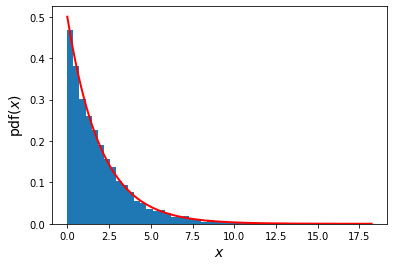

In [22]:
# Generate samples from the exponential distribution.

# Exponential distribution
def exp_pdf(x, gamma):
    return np.exp(-x / gamma) / gamma


def exp_cdf(x, lambd):
    return 1.0 - np.exp(-x / gamma)


def exp_inverse_cdf(p, gamma):
    return -gamma * np.log(1.0 - p)


# Inverse transform sampling.

gamma = 2.0

n_samples = 10000
U = np.random.rand(n_samples)  # U ~ U[0, 1]
X = exp_inverse_cdf(U, gamma)

# Define a range for the plot.

X_min, X_max = (np.min(X), np.max(X))

fontsize = 14
fig, ax = stoch.plot_pdf(
    X,
    lambda x: exp_pdf(x, gamma),
    fontsize=fontsize,
    fig_num=1,
)
_ = ax.set_xlabel("$x$", fontsize=fontsize)
_ = ax.set_ylabel("pdf($x$)", fontsize=fontsize)

## Exponential kernel in 1 dimension

The exponential kernel in 1 dimension is
$$
k(x, x') = k(x - x') = \exp\left(- \frac{\left|x - x' \right|}{\gamma} \right).
$$

####  Q1. Express this kernel as the Fourier transform of a density $\hbox{pdf}(x)$.
$$
k(x) = \int_{-\infty}^{\infty} e^{i w x} \text{pdf}(w) dw.
$$
The density is proportional to the  the inverse Fourier transform of $k(x)$
$$
\hbox{pdf}(w) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i x w} k(x) dx 
$$

**Solution**.

We take $k(x) = e^{\frac{-|x|}{\gamma}}$, with $\gamma > 0$. If we evaluate in $x=0$, then $k(0) = 1$.

$$
\begin{align*}
\hbox{pdf}(w)  = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i x w} e^{\frac{|x|}{\gamma}} dx
              &= \frac{1}{2 \pi} \int_{-\infty}^{0}  e^{-i x w - \frac{x}{\gamma}} dx + \frac{1}{2 \pi} \int_{0}^{\infty} e^{-i x w - \frac{x}{\gamma}} dx \\
              &= \frac{1}{2\pi} \left[ \left[- \frac{e^{-i x w - \frac{x}{\gamma}}}{i w - \frac{x}{\gamma}} \right]_{-\infty}^0 + \left[ - \frac{e^{-i x w - \frac{x}{\gamma}}}{i w + \frac{x}{\gamma}} \right]_0^{\infty}\right] \\
              &= \frac{1}{2\pi} \left[ \left( \frac{-1}{iw-\frac{1}{\gamma}} \right) + \lim_{x \to -\infty} \left( \frac{e^{-ixw}e^{\frac{-x}{\gamma}}}{iw - \frac 1 \gamma }\right)   -    \left( \frac{1}{iw+\frac{1}{\gamma}} \right) + \lim_{x \to \infty} \left( \frac{e^{-ixw}e^{\frac{-x}{\gamma}}}{iw + \frac 1 \gamma }\right) \right] \\
              (*) &= \frac{1}{2\pi} \left( \frac{-1}{iw - \frac{1}{\gamma}} - \frac{1}{iw + \frac{1}{\gamma}} \right) \\
              &= \frac 1 \pi \left( \frac{-1}{-\gamma w^2 - \frac 1 \gamma} \right) \\
              &= \frac 1 \pi \frac \gamma \gamma \frac{1}{\gamma w^2 + \frac 1 \gamma} \\
              &= \frac{\gamma}{\pi\gamma^2 w^2 + \pi}.
\end{align*}
$$

(\*) *Note that $e^{-iwx}$ is bounded and $e^{\frac{-x}{\gamma}}$ tends to zero, so all expression tends to zero.*

We see that this is pretty similar to a Cauchy PDF. In fact, we could transform this expression, setting scale parameter as $\frac 1 \gamma$:

$$
\hbox{pdf}(w) =  \frac{\gamma}{\pi\gamma^2 w^2 + \pi} = \frac{\gamma}{\pi \left( w^2 \gamma^2 + 1 \right)} = \frac{1}{\pi \gamma' \left[ \left( \frac{x - x_0}{\gamma'} \right)^2 + 1 \right]}.
$$

We prove our intuition by setting $x_0 = 0$ . Notice that $\gamma$ and $\gamma'$ are not the same parameter, so $\gamma$ is our rate parameter and $\gamma'$ is the Cauchy scale parameter. *See [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)*.

    
####  Q2. Derive the cdf and inverse of the cdf for $\hbox{pdf}(w)$. 
The corresponding cumulative distribution function is:
$$
\hbox{cdf}(w) = \int_{-\infty}^w \hbox{pdf}(w') dw'
$$
  
**Solution**.

Following the expression above,

$$
\begin{align*}
F(w) = \int_{-\infty}^w \hbox{pdf}(x) dx = \int_{-\infty}^w  \frac{\gamma}{\pi\gamma^2 w^2 + \pi} dx = \frac \gamma \pi \int_{-\infty}^w \frac{1}{\gamma^2 x^2 + 1} dx.   
\end{align*}
$$

We solve this integral via [WolframAlpha](https://www.wolframalpha.com/input?i2d=true&i=Divide%5Bγ%2Cπ%5DIntegrate%5BDivide%5B1%2CPower%5Bγ%2C2%5DPower%5Bx%2C2%5D%2B1%5D%2C%7Bx%2C-∞%2Cω%7D%5D),


$$
\begin{align*}
F(w) = \frac{2 \arctan (\gamma w) + \pi}{2\pi} = \frac{\arctan (\gamma w)}{\pi} + \frac 1 2.
\end{align*}
$$

If we take again $w = \frac{x - x_0}{\gamma}$, we clearly see that this result corresponds to the [Cauchy CDF](https://en.wikipedia.org/wiki/Cauchy_distribution).

Finally, we get the inverse:

$$
F^{-1} (p) = \frac 1 \gamma \tan \left( \pi \left( p - \frac 1 2 \right) \right).
$$


#### Q3. Use the method of the inverse to generate random numbers sampled from this $\text{pdf}(w)$.

First, we define all *pdf* and *cdf* calculated above.

In [2]:
def kernel_exp_pdf(gamma, x):
    """Computes exponential kernel pdf"""
    return gamma / np.pi * 1 / (gamma**2 * x**2 + 1)


def kernel_exp_cdf(gamma, x):
    """Computes exponential kernel cdf"""
    return np.arctan(gamma * x) / np.pi + 0.5


def kernel_exp_inverse_cdf(gamma, p):
    """Computes inverse of the cdf functionn from exponential kernel"""
    return 1 / gamma * np.tan(np.pi * (p - 0.5))

Then, we generate random numbers sampled from *pdf(w)* using the method of the inverse.

Text(0.5, 1.0, 'Inverse transform sampling from pdf $(x)$ fixed')

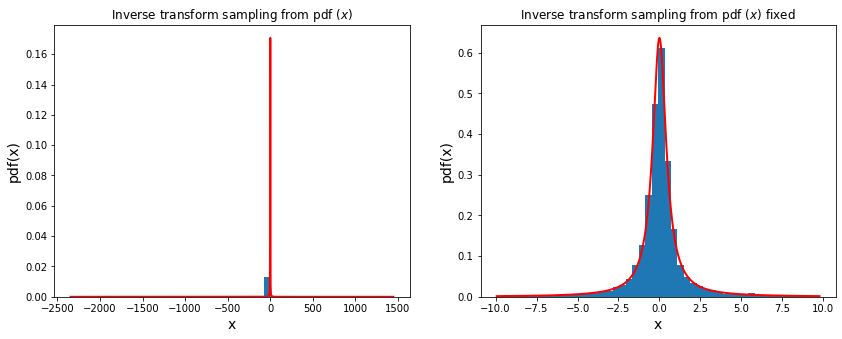

In [3]:
# Number of samples
n = 10000

# Gamma parameter
gamma = 2.0

# u ~ U[0, 1]
u = np.random.rand(n)

# Inverse transform sampling
X = kernel_exp_inverse_cdf(gamma, u)

# Plots
_, ax = plt.subplots(1, 2, figsize=(14, 5))

_ = stoch.plot_pdf(
    X,
    lambda x: kernel_exp_pdf(gamma, x),
    fontsize=14,
    ax=ax[0],
)

# Try clipping axis
X_ = X[np.abs(X) < 10.0]

_ = stoch.plot_pdf(
    X_,
    lambda x: kernel_exp_pdf(gamma, x),
    fontsize=14,
    ax=ax[1],
)

# Set titles
ax[0].set_title(r"Inverse transform sampling from pdf $(x)$")
ax[1].set_title(r"Inverse transform sampling from pdf $(x)$ fixed")

## Exponential kernel in $D$ dimensions.

Consider the exponential kernel in $D$ dimensions
$$ k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x}- \mathbf{x}') = \exp\left\{- \frac{\lVert \mathbf{x}- \mathbf{x}' \rVert_1}{\gamma} \right\},$$
with the $L_1$ norm
$$ \lVert \mathbf{x}- \mathbf{x}' \rVert_1 = \sum_{d=1}^D \left|x_d \right|.$$

The Fourier transform of the exponential kernel in $D$ dimensions is proportional to a pdf:
$$
\text{pdf}(\mathbf{w}) \propto \int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left\{- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right\} d \mathbf{x}.
$$

#### Q4. Compute the Fourier transform of the exponential kernel in $D$ dimensions.
The inverse Fourier transform of a translationally invariante kernel
$$
k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x} - \mathbf{x}').
$$
is
$$
\text{pdf}(\mathbf{w}) = \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{- i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) d\mathbf{x}
$$

**Solution**.

$$
\begin{align*}
\hbox{pdf}(\mathbf{w}) 
    &= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{- i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) d\mathbf{x} \\
    &= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} \exp \left\{ -i w^T x \right\} \exp \left\{ \frac{- \lVert \mathbf{x} \rVert_1}{\gamma} \right\} d\mathbf{x}.
\end{align*}
$$

We apply previous definition of $L_1$ norm. Notice that we have $D$ dimensions and $\mathbf{x}$ and $\mathbf{w}$ are vectors of size $D$. Then we have,

$$
\begin{align*}
\hbox{pdf}(\mathbf{w})
    &= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} \exp \left\{ - \sum_{d=1}^D i w_d x_d - \frac{| \mathbf{x_d}|}{\gamma} \right\} d\mathbf{x}.
\end{align*}
$$

Now we notice that in $D$ dimensions space it is equivalent to the expression below.

$$
\hbox{pdf}(\mathbf{w})
    = \prod_{d=1}^{D} \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} \exp \left\{ - i w_d x_d \right\} \exp \left\{ - \frac{| \mathbf{x_d}|}{\gamma} \right\} d\mathbf{x}
    = \prod_{d=1}^{D} \hbox{pdf}(w).
$$



#### Q5. Use the method of the inverse to generate random numbers sampled from $\text{pdf}(\mathbf{w})$.

*Hint:* If the 1D implementation is vectorized, the answer to this question is straightforward.

As we noticed before, it seems that we can sample from the multivariate probability distribution assuming that every *pdf* is independent.

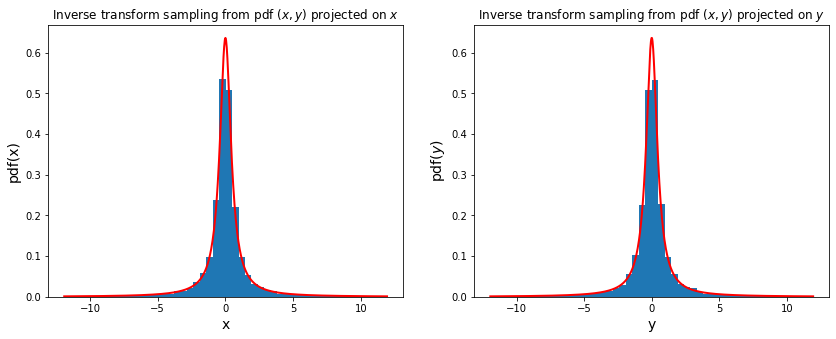

In [4]:
# Set n dimensions
D = 2

# Sampling parameters
gamma = 2.0
n = 10000

# u ~ U[0, 1]
u = np.random.rand(n, D)

# Inverse transform sampling
X = kernel_exp_inverse_cdf(gamma, u)

# Plot histogram vs pdf on each dimension
_, ax = plt.subplots(1, 2, figsize=(14, 5))

# Clipping axis
X_ = X[np.array(np.abs(X) < 12.0).all(axis=1)].T

_ = stoch.plot_pdf(
    X_[0],
    lambda x: kernel_exp_pdf(gamma, x),
    ax=ax[0],
    fontsize=14,
)

_ = stoch.plot_pdf(
    X_[1],
    lambda x: kernel_exp_pdf(gamma, x),
    ax=ax[1],
    fontsize=14,
)

ax[0].set_title(r"Inverse transform sampling from pdf $(x, y)$ projected on $x$")
ax[1].set_title(r"Inverse transform sampling from pdf $(x, y)$ projected on $y$")
ax[1].set_ylabel(r"pdf$(y)$")
ax[1].set_xlabel(r"y")
plt.show()

In [5]:
centering = lambda bins: (bins + (bins[1] - bins[0]) / 2)[:-1]

x, y = X[:, 0], X[:, 1]
X_ = np.array(
    [
        [X[:, 0][i], X[:, 1][i]]
        for i in range(x.shape[0])
        if np.abs(x[i]) < 5.0 and np.abs(y[i]) < 5.0
    ]
)

fig = plt.figure()
hist = np.histogram2d(X_[:, 0], X_[:, 1], bins=42)
final_data = pd.DataFrame(
    hist[0] / len(hist[0]), index=centering(hist[1]), columns=centering(hist[2])
)
fig = go.Figure(data=[go.Surface(z=final_data, colorscale="twilight")])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, project_z=True))
fig.update_layout(
    title="Inverse transform sampling 3D",
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
)
fig.show()

<Figure size 432x288 with 0 Axes>




#### Q6. Write code to generate random Fourier Features corresponding to the exponential kernel in D dimensions.

Complete the code for the class 

```python
class RandomFeaturesSamplerExp(RandomFeaturesSampler):
```
in the file 
``` 
kernel_approximation.py
```



### Generation of Random Fourier Features: Alternative sampling scheme.

Consider the translationally invariant kernel $k\left(\mathbf{x}, \mathbf{x}'\right) = k\left(\mathbf{x} - \mathbf{x}'\right)$, with $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$.

Acording to Bochner's theorem, this type of kernel can be expressed as the Fourier transform of a (possibly not normalized) density $p(\mathbf{w})$
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) e^{i \mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right)}.
$$
Since the kernel funtion is real and symmetric, this expression can be written as 
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) \cos \left(\mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right) \right).
$$

Show that the set of random features
$$
\left\{ \left( \cos \mathbf{w}^T \mathbf{x}, \sin \mathbf{w}^T \mathbf{x} \right); \mathbf{w} \sim p(\mathbf{w})\right\}.
$$
and the set 
$$
\left\{\sqrt{2} \cos \left(\mathbf{w}^T \mathbf{x} + b \right); \ \mathbf{w} \sim p(\mathbf{w}); \ b \sim U[0 , 2 \pi]; \ \mathbf{w} \perp b\right\}
$$
provide the same approximation of the kernel.

#### The kernel approximation using the first type of features is
$$
k\left(\mathbf{x}, \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}, \, \sin \mathbf{w}^T \mathbf{x} \right) \left( \cos \mathbf{w}^T \mathbf{x}', \, \sin \mathbf{w}^T \mathbf{x}' \right)^T 
= \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}  \, \cos \mathbf{w}^T \mathbf{x}' + \sin \mathbf{w}^T \mathbf{x} \,  \sin \mathbf{w}^T \mathbf{x}' \right) = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right).
$$

#### Q7. Derive the kernel approximation using the second type of features.

**Solution**.

We can denote the first set as $\Phi_w^{(1)}$, and the second set as $\Phi_{w,b}^{(2)}$, so $k(x-x') = \mathbb{E} \left[ \Phi^{T}(x) \Phi (x') \right]$. Following the approximation above, we can derive the kernel approximation using the second type of features as follows:

$$
\begin{align*}
    \mathbb{E}_{w,b} \left[ \left( \Phi^{(2)}_{w} (x) \right)^T \Phi^{(2)} (x') \right] &= \mathbb{E}_{w,b} \left[ 2\cos(w^Tx+b)\cos(w^Tx'+b) \right] \\
                                                                                    (1^*) &= \mathbb{E}_{w,b} \left[ \cos(w^Tx + b + w^Tx' + b) + \cos(w^Tx + b - w^Tx' - b) \right] \\
                                                                                          &= \mathbb{E}_{w,b} \left[ \cos (w^T(x + x') + 2b)) + \cos(w^T(x - x'))\right] \\
                                                                                    (2^*) &= \mathbb{E}_w \big[ \underbrace{\mathbb{E}_b \left[ \cos (w^T(x + x') + \cancel{2b}^{0})) \right]}_{0} 
                                                                                                                            + \mathbb{E}_b \left[ \cos(w^T(x - x')) \right] \big] \\
                                                                                          &= \mathbb{E}_w \left[ \mathbb{E}_b (\cos (w^T (x-x'))) \right] \\
                                                                                    (3^*) &= \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right) \\
                                                                                          &= k(x-x').
\end{align*}
$$

*$(1^{*})$* Remember that $2\cos \alpha \cos \beta = \cos(\alpha + \beta) + \cos(\alpha - \beta)$.

*$(2^{*})$* Linearity of expectation.

*$(3^{*})$* Böchner theorem.

*Bibliography: [Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)*.

#### Q8. Implement the sampling method based on the second type of random features.

Fill in the corresponding code in the file 
``` 
kernel_approximation.py
```
We implemented this sampling method following a Monte Carlo sampling scheme. First, we generate an *iid* sample  $\left\{ \mathbf{w} \sim p(\mathbf{w}); j = 1,...,J \right\}$. Then, we compute the random features, approximating the expression above to a finite series

$$
\begin{align*}
    k(x-x') &\approx \frac 1 J \sum_{j=1}^J \left(  \left( \Phi^{(2)}_{w} (x) \right)^T \Phi^{(2)} (x') \right)
            &=^* \sum_{j=1}^J \sqrt{\frac 2 J} \left( \hat \Phi^{(2)}_{w} (x) \right)^T  \sqrt{\frac 2 J}  \hat \Phi^{(2)} (x') \underset{J \to \infty}{\to} k(x-x')
\end{align*}
$$

*(\*)* Note that $\left( \Phi^{(2)}_{w} (x) \right)^T \Phi^{(2)} (x') = 2\cos(w^Tx+b)\cos(w^Tx'+b)$.


#### Q9. Illustrate that both types of feaures approximate the exponential kernel when $p(\mathbf{w})$ is the inverse Fourier transform of the exponential kernel in $D$ dimensions. 



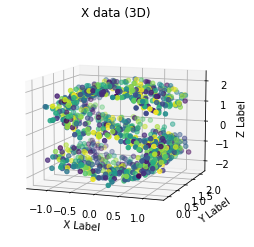

In [7]:
## Generate data
# 3-D data
n_instances = 1000
X, t = datasets.make_s_curve(n_instances, noise=0.1)
X = X[np.argsort(t)]

# Plots
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("X data (3D)")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t)
ax.view_init(10, -70)
plt.show()

In [9]:
X.shape

(1000, 3)

In [10]:
# Approximate the exponential kernel using Random Fourier Features.

length_scale = 2.0
A = 1.0


def kernel(X, Y):
    return kml.exponential_kernel(X, Y, A=1.0, l=length_scale)


n_random_features = [10, 100, 1000, 10000]

#  First class of features
rf1 = ka.RandomFeaturesSamplerExp(
    n_features_sampled=4,
    sampling_method="sin+cos",
    length_scale_kernel=length_scale,
)

#  Second class of features
rf2 = ka.RandomFeaturesSamplerExp(
    n_features_sampled=4,
    sampling_method="cos",
    length_scale_kernel=length_scale,
)

# of features =  10
# of features =  100
# of features =  1000
# of features =  10000


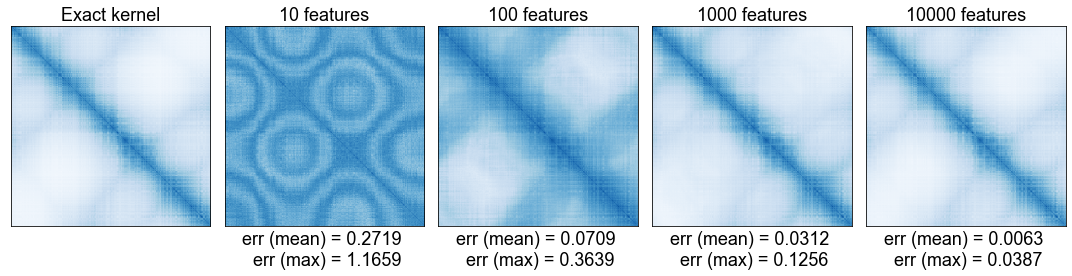

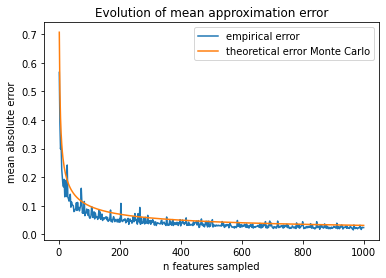

In [11]:
## Plot the approximation to the kernel matrix
ka.demo_kernel_approximation_features(X, kernel, rf1, n_random_features)

## Plot the error evolution with each kernel matrix
ka.demo_kernel_approximation_error_evolution(X, kernel, rf1, n_instances)

# of features =  10
# of features =  100
# of features =  1000
# of features =  10000


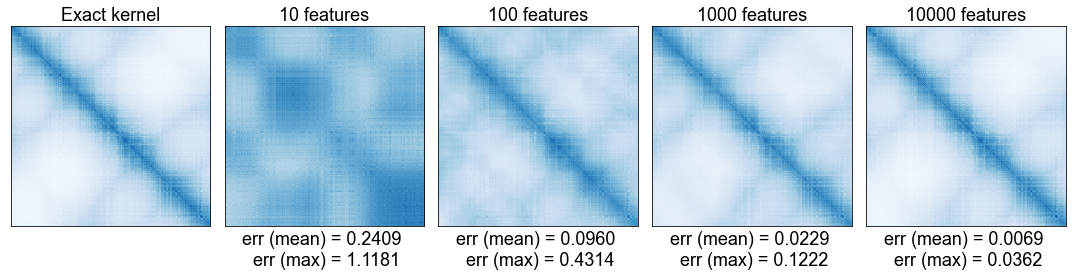

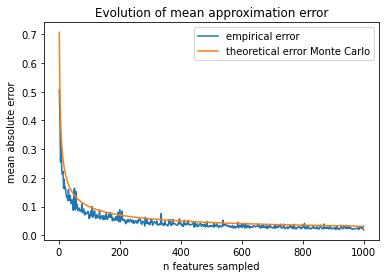

In [12]:
## Plot the approximation to the kernel matrix
ka.demo_kernel_approximation_features(X, kernel, rf2, n_random_features)

## Plot the error evolution with each kernel matrix
ka.demo_kernel_approximation_error_evolution(X, kernel, rf2, n_instances)

### Q10. Train and evaluate different classifiers.

Solve the classification problem using different kernel methods using the same data in

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py

**To get more stable results, the process should be repeated for $10$ different random train / test partitions of the data.**

Using 5-fold cross validation on the training data, determine the optimal values of the hyperparameter for the following cases: 
1. Non-linear SVM + RBF kernel [C, gamma]
2. Linear SVM + RBF random features [C, gamma, n_features]
3. Linear SVM + RBF Nyström features [C, gamma, n_features]
4. Non-linear SVM + exponential kernel [C, length_scale] 
5. Linear SVM + exponential random features [C, length_scale, n_features]
6. Linear SVM + exponential Nyström features [C, length_scale, n_features]

##### NOTES
* Determine the hyperparameter grid on which the search is made using references from the literature. Include those references in the Chicago citation format ( https://www.chicagomanualofstyle.org/tools_citationguide/citation-guide-2.html).

* It may be useful to vary one of the hyperparameters while keeping the other fixed (include those plots in your report). For instance, for $n_{features}$. 

##### REPORT:
* Plot the curve that traces the dependence of the CV, training and test error as a function of $n_{features}$ for a fixed value of the other parameters.
* Train final models with the values of the optimal hyperparameters.  
* Provide in a table the mean and the standard deviation of the training error, the cross-validation error and test error for each of the 6 methods considered.
* Provide in a table the mean and the standard deviation of the times for the cross-validation step, for the final training time, and for the prediction time in the test set. To this end, use the Python library $\texttt{timeit}$.

### Sklearn resources.

1. Non-linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

2. Linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

3. Cross-validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

4. Timing and accuracy plots for random Fourier Features and Nyström features: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html

### Solution

---------------

#### Bibliography

(1) [Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)

(2) [Digits data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

(3) [Explicit feature map approximation for RBF kernels](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)

(4) [A Practical Guide to Support Vector Classification](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)

First, we load *digits data*$ ^{2}$ and check data shape.

In [13]:
# Load digits data and check shape
digits = datasets.load_digits()
digits.data.shape

(1797, 64)

So we have 1797 total samples and a dimensionality of 64.

In [14]:
n_samples, n_features = digits.data.shape

We visualize an example to verify we are loading this data correctly.

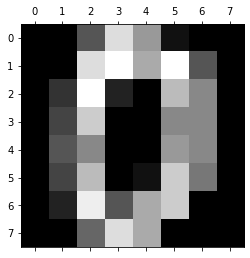

In [15]:
# Plot an example
plt.matshow(digits.images[0])
plt.gray()

We need to flatten the image in order to turn the data in a (samples, features) matrix $^3$, and save target values.

In [16]:
# Normalized data
data = digits.data / np.max(digits.data) - digits.data.mean(axis=0)

# Save target for predictions
target = digits.target

Now it's time to select our parameters for search space. We decided to set a considerable number of features, as it is said in [Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf). However, we have not chosen much more range of features as the execution time would be much longer and for this test we wanted to narrow it down a bit. However, in the future this aspect could be studied to see to what extent it influences the results. For the moment we will leave it with a medium amount.

In [17]:
# Set n features
n_features_sampled = [20, 50, 100, 200, 400]

Another parameters that are important to set is $C$ and $\gamma$ (`gamma` and `length_scale`). We have seen in [A Practical Guide to Support Vector Classification](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) that they recommend values for $C$ in the order of $2^{-5}$ and $2^{15}$ and for $\gamma$, $2^{-15}$, $2^{-13}$ (see page 5), so we select similar values. We also realized that we have to reproduce the same Sklearn's scheme, so we set the grid as `1.0 / n_features`.

In [18]:
# Search space for C (normalized)
C = np.logspace(-5, 3, 15, base=2.0) * 2.0 / n_samples

# Grid
space = 1.0 / n_features

#C
C_space = np.append(C, space)

# Gamma
C_scale = np.logspace(-10, 5, 10, base=2.0)

Now we construct the parameters we will use for GridSearch.

In [19]:
parameters = [
    #  Non-linear SVM + RBF kernel [C, gamma]
    {
        "svc_sk_rbf__C": C_space, 
        "svc_sk_rbf__gamma": C_scale
    },
    #  Linear SVM + RBF random features [C, gamma, n_features]
    {
        "svc_sk__C": C_space,
        "rbf_features__gamma": C_scale,
        "rbf_features__n_components": n_features_sampled,
    },
    #  Linear SVM + RBF Nyström features [C, gamma, n_features]
    {
        "svc_sk__C": C_space,
        "nystroem_rbf_features__gamma": C_scale,
        "nystroem_rbf_features__n_components": n_features_sampled,
    },
    #  Non-linear SVM + exponential kernel [C, length_scale]
    {
        "svc_sk_exp__C": C_space, 
        "svc_sk_exp__kernel__gamma": C_scale
    },
    #  Linear SVM + exponential random features [C, length_scale, n_features]
    {
        "svc_sk__C": C_space,
        "exp_features__length_scale_kernel": C_scale,
        "exp_features__n_features_sampled": n_features_sampled,
    },
    #  Linear SVM + exponential Nyström features [C, length_scale, n_features]
    {
        "svc_sk__C": C_space,
        "nystroem_exp_features__gamma": C_scale,
        "nystroem_exp_features__n_components": n_features_sampled
    },
]

Time to construct every pipeline for our models. Note that we use `PairwiseKernel(metric="laplacian")` for Sklearn's exponential kernel.

In [20]:
models = [
    # Non-linear SVM + RBF kernel [C, gamma]
    (
        pipeline.Pipeline([("svc_sk_rbf", svm.SVC(kernel="rbf", random_state=1))]),
        "Non-linear SVM + RBF kernel [C, gamma]",
    ),
    # Linear SVM + RBF random features [C, gamma, n_features]
    (
        pipeline.Pipeline(
            [
                ("rbf_features", RBFSampler(random_state=1)),
                ("svc_sk", svm.LinearSVC(random_state=1, dual=False)),
            ]
        ),
        "Linear SVM + RBF random features [C, gamma, n_features]",
    ),
    # Linear SVM + RBF Nyström features [C, gamma, n_features]
    (
        pipeline.Pipeline(
            [
                ("nystroem_rbf_features", Nystroem(kernel="rbf", random_state=1)),
                ("svc_sk", svm.LinearSVC(random_state=1, dual=False)),
            ]
        ),
        "Linear SVM + RBF Nyström features [C, gamma, n_features]",
    ),
    # Non-linear SVM + exponential kernel [C, length_scale]
    (
        pipeline.Pipeline(
            [
                (
                    "svc_sk_exp",
                    svm.SVC(kernel=PairwiseKernel(metric="laplacian"), random_state=1),
                )
            ]
        ),
        "Non-linear SVM + exponential kernel [C, length_scale]",
    ),
    # Linear SVM + exponential random features [C, length_scale, n_features]
    (
        pipeline.Pipeline(
            [
                ("exp_features", ka.RandomFeaturesSamplerExp()),
                ("svc_sk", svm.LinearSVC(random_state=1, dual=False)),
            ]
        ),
        "Linear SVM + exponential random features [C, length_scale, n_features]",
    ),
    # Linear SVM + exponential Nyström features [C, length_scale, n_features]
    (
        pipeline.Pipeline(
            [
                ("nystroem_exp_features", Nystroem(kernel="laplacian", random_state=1)),
                ("svc_sk", svm.LinearSVC(random_state=1, dual=False)),
            ]
        ),
        "Linear SVM + exponential random features [C, length_scale, n_features]",
    ),
]

Then, we implement the requested procedure, with $K=5$ and $10$ iterations. Note that we did a 70-30 partition for train/test, which seems to be nice for a trial. Future work could test the effect of this or consult more references.

In [21]:
K = 5
times = 10
results = defaultdict()

for n in range(times):
    print("\t\t\t -------- Time {}--------".format(n))

    # Train - test partition
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, train_size=0.7, stratify=target, random_state=42+n
    )

    # Set Stratified 5-Fold
    CV_ = StratifiedKFold(K, shuffle=True, random_state=42)

    results[n] = []

    # Grid search
    for job, ((model, name), param_grid) in enumerate(zip(models, parameters)):

        clf = GridSearchCV(
            model, param_grid, cv=CV_, refit=True, n_jobs=-1, return_train_score=True
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            clf.fit(X_train, y_train)
        print(" - Best parameters set found on development set:\n\t*", clf.best_params_)

        test_score = clf.score(X_test, y_test)
        print(f" - Test score: {test_score:.3f}\n")

        results[job] = [model, name, param_grid, clf.best_estimator_, clf.best_params_, clf.best_score_, test_score]

			 -------- Time 0--------
